In [58]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3060
Using device: cuda


In [59]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import copy
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

root_dir = "D:/"
project_folder = "CSE_Research_Projects/CSE498R/"
os.chdir(root_dir+project_folder)

# Print the current directory
print("Current directory:", os.getcwd())

plt.ion()

# import warnings
# warnings.filterwarnings('ignore')

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if use_gpu:
    print("Using CUDA")
else:
  print("Not Using CUDA")

PyTorch Version:  2.4.0+cu118
Torchvision Version:  0.19.0+cpu
Current directory: D:\CSE_Research_Projects\CSE498R
Using CUDA


In [60]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "D:/CSE_Research_Projects/CSE498R/Dermnet_datasets"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception, efficientNet]
model_name = "vgg"

# Number of classes in the dataset
num_classes = 23

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# Model will be train when true
train_model = True

# Make new split on dataset
dataset_split = False

In [61]:
# # !pip install split-folders
# if dataset_split:
#   import splitfolders
#   # !unzip '/content/drive/My Drive/Thesis/dataset'
#   splitfolders.ratio(data_dir+'/caltech-101', output=data_dir+'/transfer_learnng_dataset_spilited', seed=1337, ratio=(0.7,0.3))

In [62]:
# !pip install split-folders
if dataset_split:
  import splitfolders
  # !unzip '/content/drive/My Drive/Thesis/dataset'
  splitfolders.ratio(data_dir+'/train', output=data_dir+'/transfer_learnng_dataset_spilited', seed=1337, ratio=(0.7,0.3))

In [63]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [64]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [65]:
import torch.nn as nn
from transformers import BeitForImageClassification, BeitFeatureExtractor
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "efficientNet":
        """ EfficientNet-B0 """
        model_ft = models.efficientnet_b0(pretrained=use_pretrained)  # Load EfficientNet-B0 model
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features  # Get input features of the last layer
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes)  # Replace the classifier layer
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224


    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224
    
    elif model_name == "vgg":
        """ VGG19_bn """
        model_ft = models.vgg19_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "beit":
        """ BEiT """
        # Use the pre-trained model from Hugging Face
        model_name = "microsoft/beit-base-patch16-224-pt22k-ft22k"
        
        # Initialize the model with pretrained weights, allowing for mismatched sizes
        model_ft = BeitForImageClassification.from_pretrained(
            model_name,
            num_labels=num_classes,
            ignore_mismatched_sizes=True  # Ignore size mismatch during loading
        ) if use_pretrained else BeitForImageClassification(config=config)
        
        # Set parameters to be optimized based on feature extraction
        set_parameter_requires_grad(model_ft, feature_extract)
        
        # Modify the classifier layer for the specific number of classes
        num_ftrs = model_ft.classifier.in_features  # Get the number of input features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)  # Create a new classifier layer
        
        input_size = 224  # Set input size for the model

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

## Starting The Training Of EfficientNet Model

In [71]:
if train_model:
    # [efficientNet, alexnet, squeezenet, beit]
    model_name = "efficientNet"
    feature_extract = True

    # Initialize the model for this run
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True)

    # Print the model we just instantiated
    print(model_ft)

    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(p=0.5),                # Horizontal flip with 50% probability
        transforms.RandomRotation(degrees=15),                 # Rotate randomly by -15 to 15 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, 
                               saturation=0.2, hue=0.1),       # Randomly change brightness, contrast, etc.
        transforms.RandomGrayscale(p=0.1),                     # Convert to grayscale with 10% probability
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

    print("Initializing Datasets and Dataloaders...")

    # Create training and validation datasets
    # image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    image_datasets = {x: datasets.ImageFolder(data_dir + '/transfer_learnng_dataset_spilited/' + x, data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Send the model to GPU
    model_ft = model_ft.to(device)
    summary(model_ft, (3, input_size, input_size))
    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()
    # Train and evaluate
    model_ft_efficientNet, train_loss_history_efficientNet, train_acc_history_efficientNet, val_loss_history_efficientNet, val_acc_history_efficientNet = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
    path = root_dir + project_folder  + 'models/' + model_name
    os.makedirs(path, exist_ok = True)
    torch.save(model_ft_efficientNet.state_dict(), os.path.join(path,'model_ft_efficientNet.pth'))
    path =root_dir + project_folder  + 'models/' + model_name + '/analysis'
    os.makedirs(path, exist_ok = True)
    torch.save(torch.tensor(train_loss_history_efficientNet), os.path.join(path,'train_loss_history_efficientNet.pth'))
    torch.save(train_acc_history_efficientNet, os.path.join(path,'train_acc_history_efficientNet.pth'))
    torch.save(torch.tensor(val_loss_history_efficientNet), os.path.join(path,'val_loss_history_efficientNet.pth'))
    torch.save(val_acc_history_efficientNet, os.path.join(path,'val_acc_history_efficientNet.pth'))

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

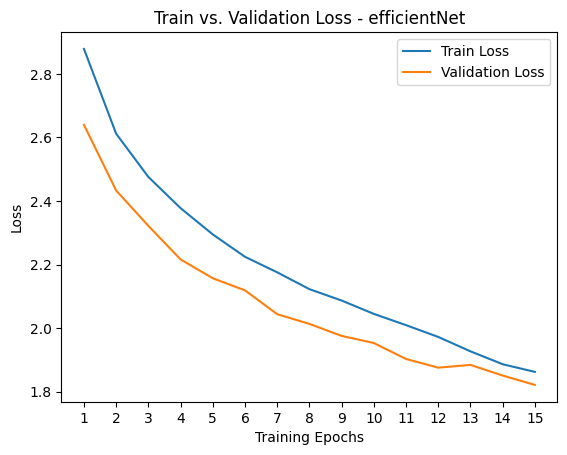

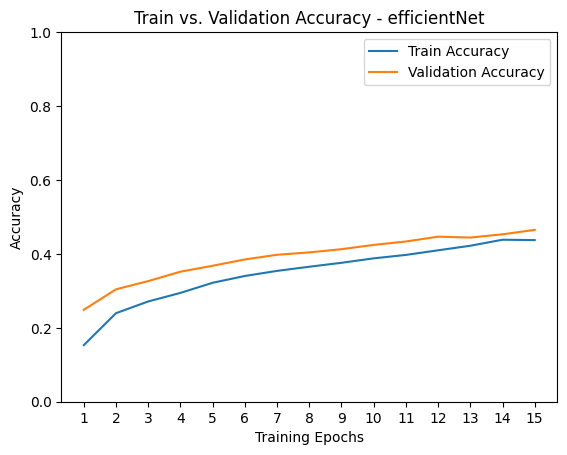

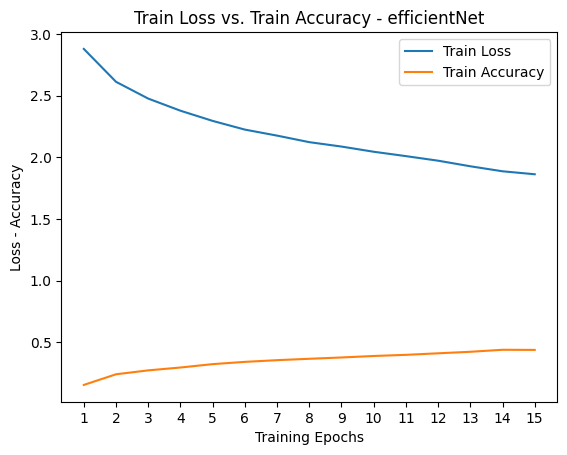

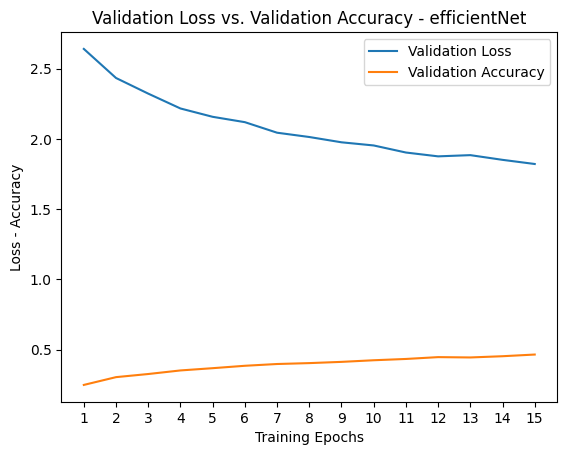

In [72]:
if train_model:
    # train_loss_history_efficientNet, train_acc_history_efficientNet, val_loss_history_efficientNet, val_acc_history_efficientNet
    t_loss_efficientNet = [np.array(h) for h in train_loss_history_efficientNet]
    v_loss_efficientNet = [np.array(h) for h in val_loss_history_efficientNet]
    plt.title("Train vs. Validation Loss - efficientNet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss")
    plt.plot(range(1,num_epochs+1),t_loss_efficientNet,label="Train Loss")
    plt.plot(range(1,num_epochs+1),v_loss_efficientNet,label="Validation Loss")
    # plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    t_acc_efficientNet = [h.cpu().numpy() for h in train_acc_history_efficientNet]
    v_acc_efficientNet = [h.cpu().numpy() for h in val_acc_history_efficientNet]
    plt.title("Train vs. Validation Accuracy - efficientNet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1,num_epochs+1),t_acc_efficientNet,label="Train Accuracy")
    plt.plot(range(1,num_epochs+1),v_acc_efficientNet,label="Validation Accuracy")
    plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Train Loss vs. Train Accuracy - efficientNet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),t_loss_efficientNet,label="Train Loss")
    plt.plot(range(1,num_epochs+1),t_acc_efficientNet,label="Train Accuracy")
    # plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Validation Loss vs. Validation Accuracy - efficientNet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),v_loss_efficientNet,label="Validation Loss")
    plt.plot(range(1,num_epochs+1),v_acc_efficientNet,label="Validation Accuracy")
    # plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()

4002
Classes: ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']
Test accurate: 1865/4002

Test acc: 46.6017

                               

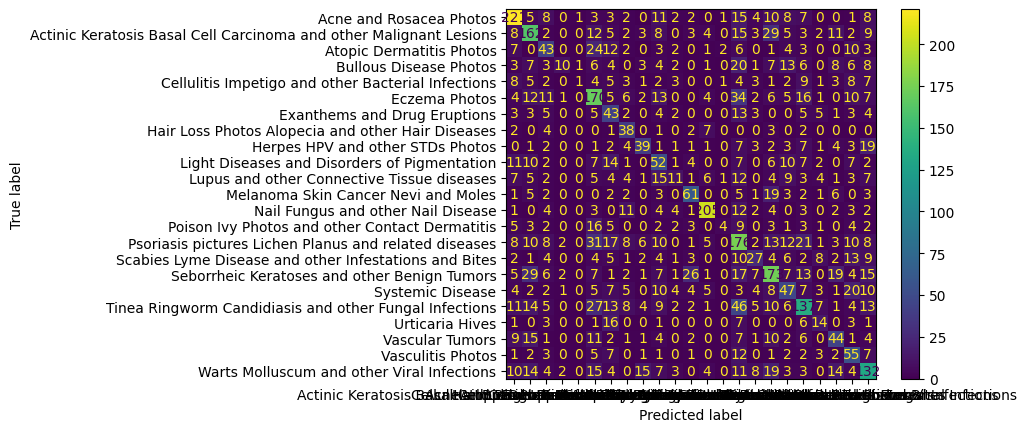

In [73]:
data_transforms = transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

testset = datasets.ImageFolder(data_dir + '/transfer_learnng_dataset_spilited/test', transform=data_transforms)
print(len(testset))
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

class_names = testset.classes
print("Classes:", class_names)

#Evaluating test dataset
total=0
correct=0
predictions = []
true_labels = []
with torch.no_grad():
    model_ft_efficientNet.eval()
    for data, target in (testloader):
        data, target = data.to(device), target.to(device)# on GPU
        outputs = model_ft_efficientNet(data)
        _,pred = torch.max(outputs, dim=1)
        true_labels=true_labels+target.squeeze().tolist()
        predictions=predictions+pred.squeeze().tolist()
        correct += torch.sum(pred==target).item()
        total += target.size(0)
        # print(f'Batch Test accurate: {torch.sum(pred==target).item()}/{target.size(0)}')
    print(f'Test accurate: {correct}/{total}\n')
    print(f'Test acc: {(100 * correct / total):.4f}\n')

print(classification_report(true_labels, predictions, target_names=class_names))
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()

## Starting The Training Of Vgg_bn19 Model



In [ ]:
if train_model:
    # [efficienNet, alexnet, squeezenet, vgg, beit]
    model_name = "vgg"
    feature_extract = True

    # Initialize the model for this run
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True)

    # Print the model we just instantiated
    print(model_ft)

    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }

    print("Initializing Datasets and Dataloaders...")

    # Create training and validation datasets
    # image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    image_datasets = {x: datasets.ImageFolder(data_dir + '/transfer_learnng_dataset_spilited/' + x, data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Send the model to GPU
    model_ft = model_ft.to(device)
    summary(model_ft, (3, input_size, input_size))
    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()
    # Train and evaluate
    model_ft_vgg, train_loss_history_vgg, train_acc_history_vgg, val_loss_history_vgg, val_acc_history_vgg = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
    path = root_dir + project_folder  + 'models/' + model_name
    os.makedirs(path, exist_ok = True)
    torch.save(model_ft_vgg.state_dict(), os.path.join(path,'model_ft_vgg.pth'))
    path =root_dir + project_folder  + 'models/' + model_name + '/analysis'
    os.makedirs(path, exist_ok = True)
    torch.save(torch.tensor(train_loss_history_vgg), os.path.join(path,'train_loss_history_vgg.pth'))
    torch.save(train_acc_history_vgg, os.path.join(path,'train_acc_history_vgg.pth'))
    torch.save(torch.tensor(val_loss_history_vgg), os.path.join(path,'val_loss_history_vgg.pth'))
    torch.save(val_acc_history_vgg, os.path.join(path,'val_acc_history_vgg.pth'))

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

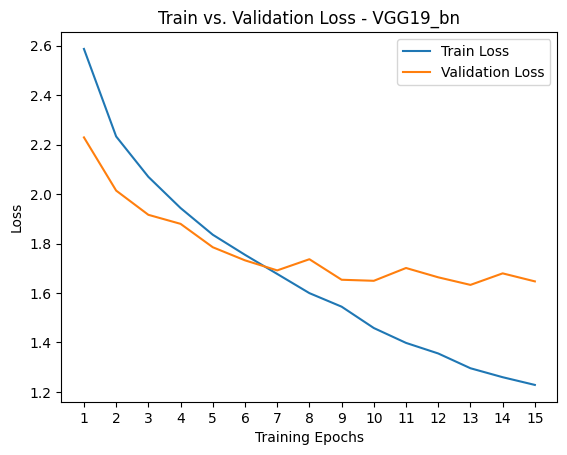

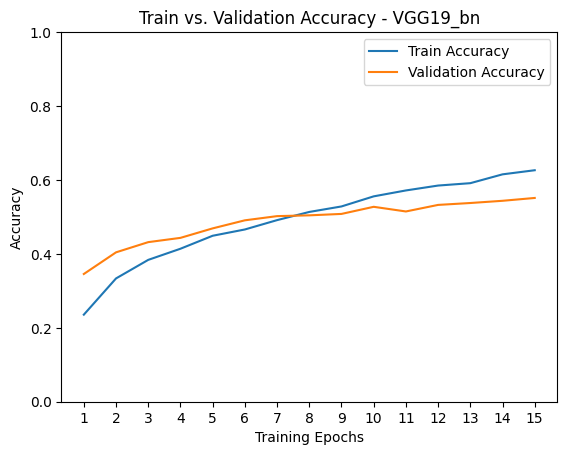

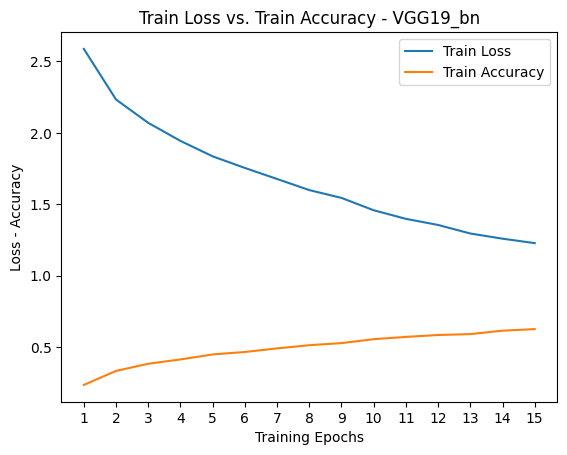

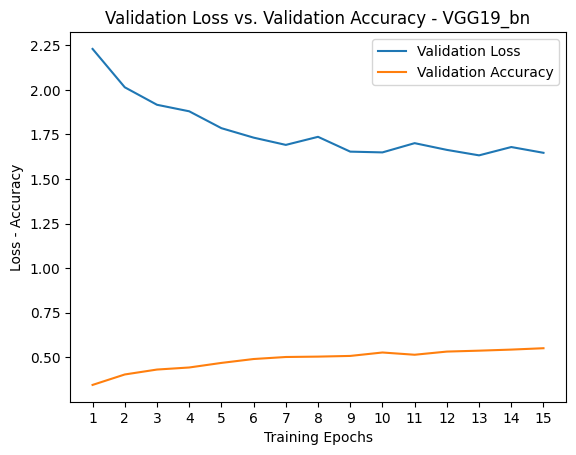

In [74]:
if train_model:
    # train_loss_history_vgg, train_acc_history_vgg, val_loss_history_vgg, val_acc_history_vgg
    t_loss_vgg = [np.array(h) for h in train_loss_history_vgg]
    v_loss_vgg = [np.array(h) for h in val_loss_history_vgg]
    plt.title("Train vs. Validation Loss - VGG19_bn")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss")
    plt.plot(range(1,num_epochs+1),t_loss_vgg,label="Train Loss")
    plt.plot(range(1,num_epochs+1),v_loss_vgg,label="Validation Loss")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    t_acc_vgg = [h.cpu().numpy() for h in train_acc_history_vgg]
    v_acc_vgg = [h.cpu().numpy() for h in val_acc_history_vgg]
    plt.title("Train vs. Validation Accuracy - VGG19_bn")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1,num_epochs+1),t_acc_vgg,label="Train Accuracy")
    plt.plot(range(1,num_epochs+1),v_acc_vgg,label="Validation Accuracy")
    plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Train Loss vs. Train Accuracy - VGG19_bn")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),t_loss_vgg,label="Train Loss")
    plt.plot(range(1,num_epochs+1),t_acc_vgg,label="Train Accuracy")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Validation Loss vs. Validation Accuracy - VGG19_bn")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),v_loss_vgg,label="Validation Loss")
    plt.plot(range(1,num_epochs+1),v_acc_vgg,label="Validation Accuracy")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()

4002
Classes: ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']
Test accurate: 2238/4002

Test acc: 55.9220

                               

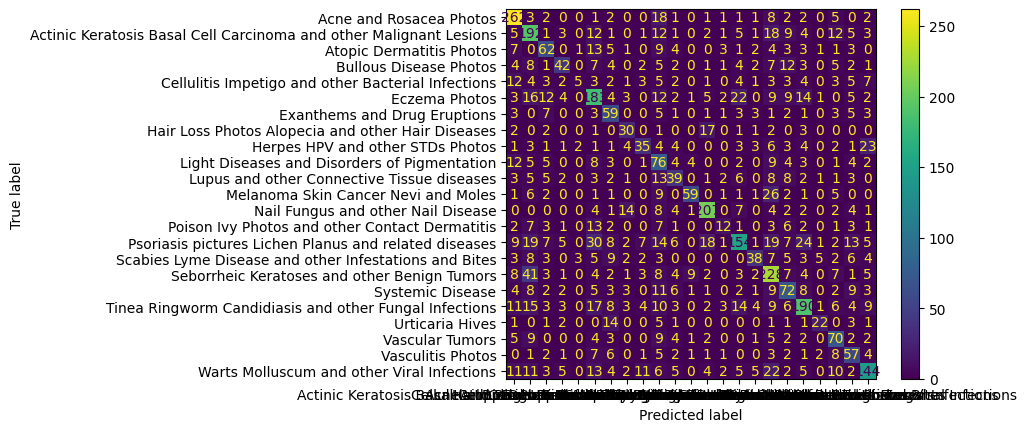

In [75]:
# Initializing transformers for test dataset
data_transforms = transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

testset = datasets.ImageFolder(data_dir + '/transfer_learnng_dataset_spilited/test', transform=data_transforms)
print(len(testset))
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Defining class names
class_names = testset.classes
print("Classes:", class_names)


#Evaluating test dataset
total=0
correct=0
predictions = []
true_labels = []
with torch.no_grad():
    model_ft_vgg.eval()
    for data, target in (testloader):
        data, target = data.to(device), target.to(device)# on GPU
        outputs = model_ft_vgg(data)
        _,pred = torch.max(outputs, dim=1)
        true_labels=true_labels+target.squeeze().tolist()
        predictions=predictions+pred.squeeze().tolist()
        correct += torch.sum(pred==target).item()
        total += target.size(0)
        # print(f'Batch Test accurate: {torch.sum(pred==target).item()}/{target.size(0)}')
    print(f'Test accurate: {correct}/{total}\n')
    print(f'Test acc: {(100 * correct / total):.4f}\n')

print(classification_report(true_labels, predictions, target_names=class_names))
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()